## Part 1

<h3><i>The attached logins file contains (simulated) timestamps of user logins. Aggregate the login counts based on 15 minute intervals, and visualize and describe the results. Please report features of demand, such as daily cycles. If there are data quality issues, report them.</i></h3>


In [1]:
import datetime
import numpy as np # Linear Algebra
import pandas as pd # Dataframes
import pandas_profiling as pp # Profiling dataframes for quick EDA
import matplotlib.pyplot as plt # Plotting
import seaborn as sns # Wrapper for Matplotlib to make prettier plots
import sklearn # Machine learning
from sklearn import preprocessing # Cleaning data for Part 3

In [2]:
# Quick profile of data. 
logins = pd.read_json('logins.json')
pp.ProfileReport(logins)

In [3]:
# Checking duplicates, mainly if there were any spikes where multiple users visited at once (or misclassifications)
# Logins.duplicated is to look for duplicates, grouped by login time. Size is to get the count of each groupby.

logins[logins.duplicated(keep=False)==True].groupby('login_time').size().sort_values(ascending=False).head(10)

login_time
1970-01-06 21:45:52    3
1970-01-09 01:31:25    3
1970-02-24 23:09:57    3
1970-02-12 11:16:53    3
1970-03-17 01:01:39    3
1970-04-04 01:17:40    3
1970-03-29 03:24:57    3
1970-04-12 04:03:15    3
1970-03-14 17:45:52    3
1970-02-22 01:32:02    2
dtype: int64

In [4]:
# Aggregates logins by 15-minute time periods. 
# Resets the index to put the time periods as the index, sets index as login time. 
# Resamples time series to every 15 minutes, counts number of logins at time period.
# The final reset_index is to use login_time as an x-axis label later on.
# Code edited from https://stackoverflow.com/questions/37842260/pandas-dataframe-resample-per-day-without-date-time-index?rq=1


by15min = logins.reset_index().set_index('login_time').resample('15min').count().reset_index()
by15min.columns = ['login_time', 'num_logins']
by15min.head()

,login_time,num_logins
0,1970-01-01 20:00:00,2
1,1970-01-01 20:15:00,6
2,1970-01-01 20:30:00,9
3,1970-01-01 20:45:00,7
4,1970-01-01 21:00:00,1


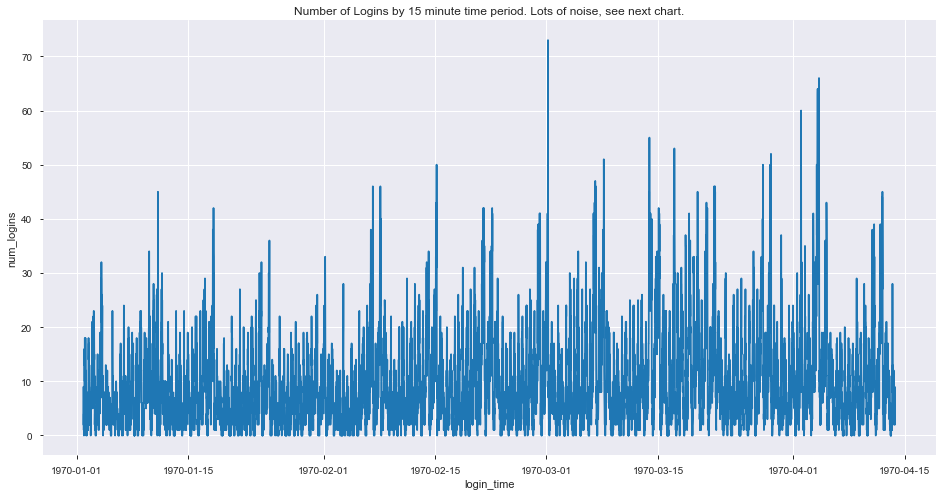

In [5]:
f, ax = plt.subplots(figsize=(16, 8))
sns.lineplot('login_time', 'num_logins', data=by15min, markers=True)
f.autofmt_xdate
ax.set_title("Number of Logins by 15 minute time period. Lots of noise, see next chart.")
plt.show()


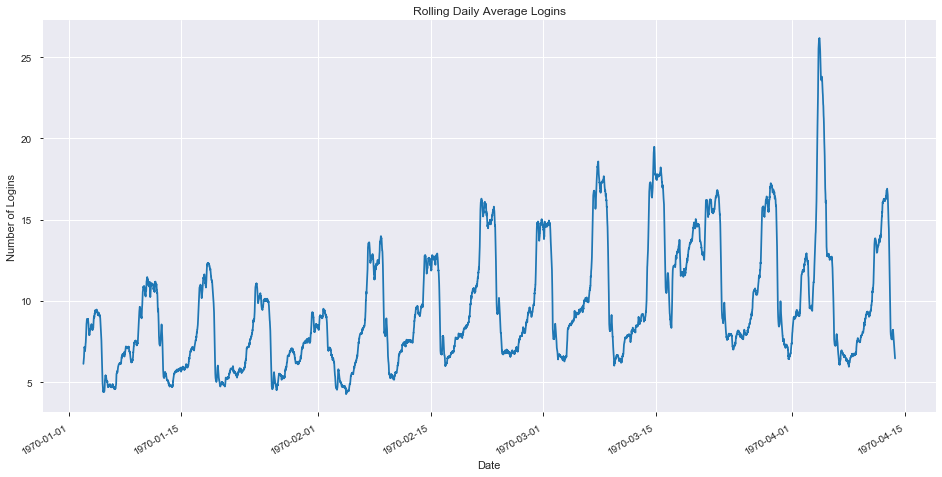

In [6]:
f, ax = plt.subplots(figsize=(16, 8))
by15min['daily_rolling'] = by15min.num_logins.rolling(window=24*4, center=False).mean()
ax.plot('login_time', 'daily_rolling', data=by15min)
ax.set_title('Rolling Daily Average Logins')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Logins')
f.autofmt_xdate()
plt.show()

<b>Year is (probably) not 1970, that's the default for UNIX timestamps without a year available.</b>

In [7]:
# For extra granularity in charts
logins['hour'] = logins.login_time.apply(lambda x: x.hour)
logins['minute'] = logins.login_time.apply(lambda x: x.minute)
logins['weekday'] = logins.login_time.apply(lambda x: x.weekday())


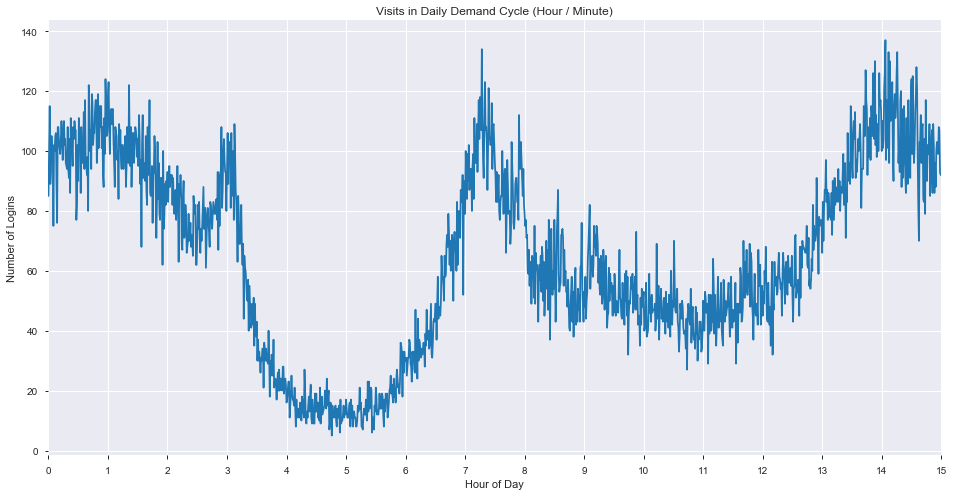

In [8]:
# Plotting counts by different levels of granularity

byday = logins.groupby(by=['hour', 'minute'])
f, ax = plt.subplots(figsize=(16, 8))
byday['login_time'].agg('count').plot()
ax.set_title('Visits in Daily Demand Cycle (Hour / Minute)')
sns.despine()
vals = ax.get_xticks()
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Number of Logins')
ax.set_xticks([x for x in range(0, 25*60, 4*24)])
ax.set_xticklabels([x for x in range(25)])
plt.show()


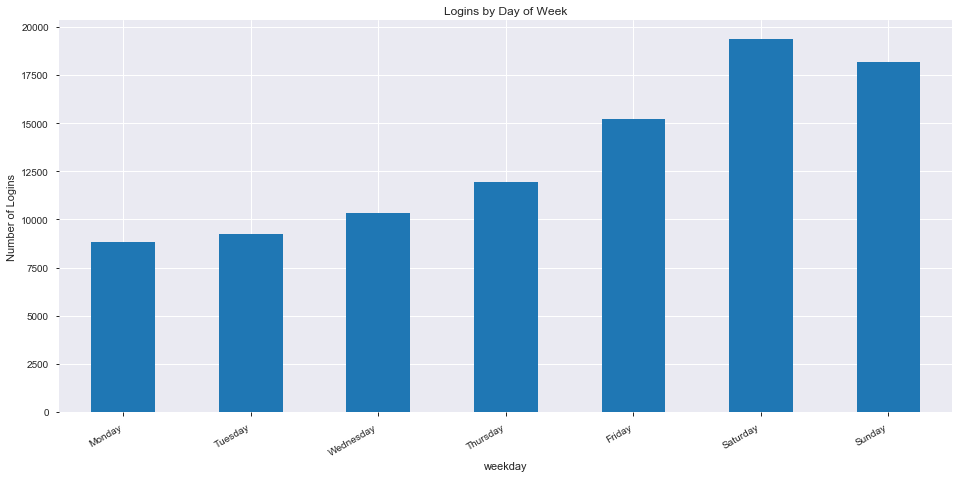

In [9]:
# Plotting counts by different levels of granularity
byweekday = logins.groupby(by='weekday')

# Day_order is to get plot in order of days of the week. Credit 
# https://stackoverflow.com/questions/47255746/change-order-on-x-axis-for-matplotlib-chart

day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
f, ax = plt.subplots(figsize=(16, 8))
byweekday['login_time'].agg('count').plot(kind='bar')
ax.set_title('Logins by Day of Week')
ax.set_label('Day of Week')
ax.set_ylabel('Number of Logins')
ax.set_xticklabels(day_order)
f.autofmt_xdate()
plt.show()


## Part 2: Experiment and Metrics design

<h4><i>The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities. However, a toll bridge, with a two-way toll, between the two cities causes driver partners to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.<br>

1.) What would you choose as the key measure of success in this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?<br>

2.) Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

A.) How you will implement the experiment<br>
B.) What statistical test(s) you will conduct to verify the significance of the observation.<br>
C.) How you would interpret the results and provide recommendations to the city operations team along with any caveats.<h4><i>

## Part 3: Predictive Modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days. We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate. The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge. 

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained? 
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance. 
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice). 


Data description

● city: city this user signed up in 
● phone:primary device for this user 
● signup_date:date of account registration; in the form ‘YYYY MM DD’ 
● last_trip_date: the last time this user completed a trip; in the form ‘YYYY MM DD’ 
● avg_dist: the average distance in miles per trip taken in the first 30 days after signup 
● avg_rating_by_driver: the rider’s average rating over all of their trips 
● avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips 
● surge_pct: the percent of trips taken with surge multiplier > 1 
● avg_surge: The average surge multiplier over all of this user’s trips 
● trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up
● ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise 
● weekday_pct: the percent of the user’s trips occurring during a weekday 


In [10]:
from pandas.io.json import json_normalize

with open('ultimate_data_challenge.json') as f:
    data = json.load(f)
    normalized = json_normalize(data)
driverdata = pd.DataFrame(normalized)    

In [11]:
pp.ProfileReport(driverdata)

In [12]:
# Filling driverdata nan's with the median of the values. 

driverdata['avg_rating_of_driver'] = driverdata['avg_rating_of_driver'].fillna(driverdata['avg_rating_of_driver'].median())
driverdata['avg_rating_by_driver'] = driverdata['avg_rating_by_driver'].fillna(driverdata['avg_rating_of_driver'].median())

In [13]:
driverdata.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [14]:
driverdata['last_trip_date'] = pd.to_datetime(driverdata['last_trip_date'])
driverdata['signup_date'] = pd.to_datetime(driverdata['signup_date'])

In [15]:
# get dates into numeric form; easier for logistic regression later.
from datetime import timedelta

driverdata['days_since_last_ride'] = (max(driverdata['last_trip_date']) - driverdata['last_trip_date']).apply(lambda x: x.days)
driverdata['days_since_signup'] = (max(driverdata['last_trip_date']) - driverdata['signup_date']).apply(lambda x: x.days)

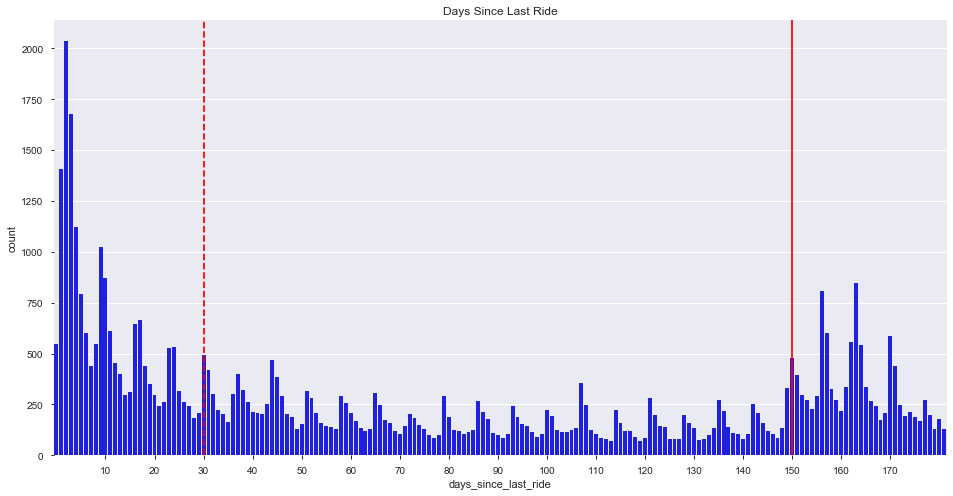

In [16]:
f, ax = plt.subplots(figsize=(16, 8))
sns.countplot(driverdata['days_since_last_ride'], color='b')
ax.set_xticks([x for x in range(10, 180, 10)])
ax.set_xticklabels([x for x in range(10, 180, 10)])
ax.axvline(x=30, color='red', ls='--')
ax.axvline(x=150, color='red')
ax.set_title('Days Since Last Ride')
plt.show()

<h3>We're looking for whether the user will remain active 150 days from now, hence the solid red line. Next, we'll do some cleaning to prepare for machine learning.</h3>

In [17]:
from sklearn import preprocessing

driverdata['boxcox_avg_dist'] = sklearn.preprocessing.power_transform(driverdata[['avg_dist']] + .001, method='box-cox', standardize=True, copy=True)
driverdata['boxcox_avg_rating_by_driver'] = sklearn.preprocessing.power_transform(driverdata[['avg_rating_by_driver']] + .001, method='box-cox', standardize=True, copy=True)
driverdata['boxcox_avg_rating_of_driver'] = sklearn.preprocessing.power_transform(driverdata[['avg_rating_of_driver']] + .001, method='box-cox', standardize=True, copy=True)
driverdata['boxcox_avg_surge'] = sklearn.preprocessing.power_transform(driverdata[['avg_surge']] + .001, method='box-cox', standardize=True, copy=True)
driverdata['boxcox_trips_in_first_30_days'] = sklearn.preprocessing.power_transform(driverdata[['trips_in_first_30_days']] + .001, method='box-cox', standardize=True, copy=True)
driverdata['boxcox_weekday_pct'] = sklearn.preprocessing.power_transform(driverdata[['weekday_pct']] + .001, method='box-cox', standardize=True, copy=True)
driverdata['boxcox_days_since_last_ride'] = sklearn.preprocessing.power_transform(driverdata[['days_since_last_ride']] + .001, method='box-cox', standardize=True, copy=True)


dd = driverdata[['boxcox_avg_dist', 'boxcox_avg_rating_by_driver', 'boxcox_avg_rating_of_driver', 'boxcox_avg_surge',
               'boxcox_trips_in_first_30_days', 'boxcox_weekday_pct']]

In [18]:
# label encoding the data plus filling in missing values

driverdata['phone'].fillna('None', inplace=True)

from sklearn.preprocessing import OneHotEncoder
oh = OneHotEncoder()

dummycols = pd.get_dummies(driverdata, columns=['city', 'phone', 'ultimate_black_user'])


In [19]:
X = dummycols[['boxcox_avg_dist', 'boxcox_avg_rating_by_driver',
       'boxcox_avg_rating_of_driver', 'boxcox_avg_surge',
       'boxcox_trips_in_first_30_days', 'boxcox_weekday_pct',
        'city_King\'s Landing', 'city_Winterfell',
       'phone_None', 'phone_iPhone', 'ultimate_black_user_True']]

In [20]:
y = driverdata.loc[:, 'days_since_last_ride'].apply(lambda x: x < 150)

In [21]:
# Split data into training and testing

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [22]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression().fit(X_train, y_train)
print("Score on test data: {:.2%}".format(lr.score(X=X_test, y=y_test)))

pd.DataFrame(lr.coef_.transpose(), columns=['Coefficients'], index=list(X.columns)).sort_values(by='Coefficients', ascending=False)

Score on test data: 80.00%


,Coefficients
city_King's Landing,0.840697
ultimate_black_user_True,0.663145
boxcox_avg_surge,0.599641
phone_iPhone,0.402360
boxcox_weekday_pct,0.365911
city_Winterfell,0.150287
boxcox_avg_dist,-0.068621
boxcox_avg_rating_of_driver,-0.265467
phone_None,-0.313642
boxcox_avg_rating_by_driver,-0.673984


In [23]:
# Function to score different machine learning models.

def score_model(clf, X_input_data, y_true):
    '''
    Scores a machine learning model, provides summary statistics, plots ROC curve.
   
    Inputs: classifier, X_input_data (X_train or X_test), y_true (y_train or y_test)
    ''' 
    
    # Scoring models. Test model. Change to allow prediction for X_train
    y_pred = clf.predict(X_input_data)

    # Fit an accuracy score
    from sklearn.metrics import accuracy_score
    print('\n Accuracy Score: \n \n', "{:.2%}".format(accuracy_score(y_true, y_pred, normalize=True)))

    # Create confusion matrix
    from sklearn.metrics import confusion_matrix
    print('\n Confusion Matrix: \n \n', confusion_matrix(y_true, y_pred))

    # Print classification report
    from sklearn.metrics import classification_report
    print('\n Classification Report: \n \n', classification_report(y_true, y_pred))

    # Generate ROC plot
    from sklearn.metrics import roc_curve
    import matplotlib.pyplot as plt

    # Compute predicted probabilities: y_pred_prob. Try except for SGD: hinge loss model.
    try:
        y_pred_prob = clf.predict_proba(X_input_data)[:,1]
        
        # Generate ROC curve values: fpr, tpr, thresholds
        fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)

        # Plot ROC curve
        f, ax = plt.subplots(figsize=(8, 8))
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr, tpr)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.show()
    
    except AttributeError:
        print('Probability estimates not available \n')
        


 Accuracy Score: 
 
 80.09%

 Confusion Matrix: 
 
 [[ 2766  7859]
 [ 2096 37279]]

 Classification Report: 
 
               precision    recall  f1-score   support

       False       0.57      0.26      0.36     10625
        True       0.83      0.95      0.88     39375

    accuracy                           0.80     50000
   macro avg       0.70      0.60      0.62     50000
weighted avg       0.77      0.80      0.77     50000



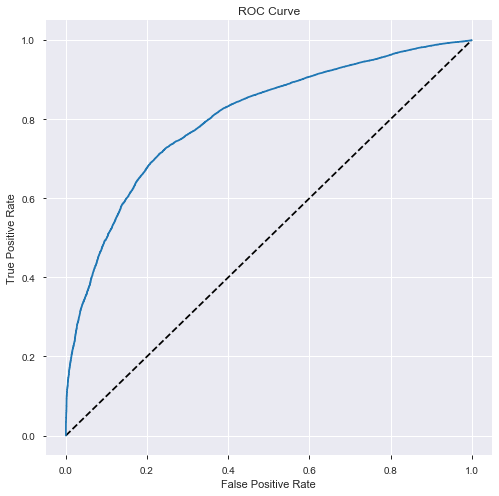

In [24]:
score_model(lr, X, y)

<h3 align='center'> Conclusion</h3>
<h3>We created a logistic regression model that can predict retention on both the testing set and the entire dataset with 80% accuracy. The biggest positive factors for retention include living in King's Landing, being an Ultimate Black User, and having a high average surge ratio. The biggest negative factors include not using the app in the first 30 days, having a low average rating by driver, or having a phone that is not on iOS or Android.</h3>